In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
#The metrics used in the testing MAPE and RMSE
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

from sklearn.metrics import mean_squared_error

#rmse = mean_squared_error(y_actual, y_predicted, squared=False)

In [2]:
#Loading the dataset
dataset1 = pd.read_csv("SolarPrediction.csv")
dataset1

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [3]:
#Processing the data
import datetime
df= dataset1.copy()
df1= df.copy()
df1['Data'] = pd.to_datetime(df['Data'], format='%m/%d/%Y %H:%M:%S AM')
df1['Data']= df1['Data'].dt.strftime('%m/%d/%Y')
df1 = df1.rename(columns={'Data': 'Date'})
Daily = df1.groupby(by="Date").mean()
Daily.index =pd.to_datetime( Daily.index, format='%m/%d/%Y')
Daily1= Daily.Radiation
Daily1.index =pd.to_datetime( Daily1.index, format='%m/%d/%Y')
Daily2=Daily1.asfreq('d')
df_final= Daily2.interpolate();
df_final

Date
2016-09-01    298.451600
2016-09-02    333.471219
2016-09-03    123.974574
2016-09-04    153.584321
2016-09-05    306.065125
                 ...    
2016-12-27    239.910556
2016-12-28    174.910278
2016-12-29    125.018049
2016-12-30     88.367684
2016-12-31    144.288542
Freq: D, Name: Radiation, Length: 122, dtype: float64

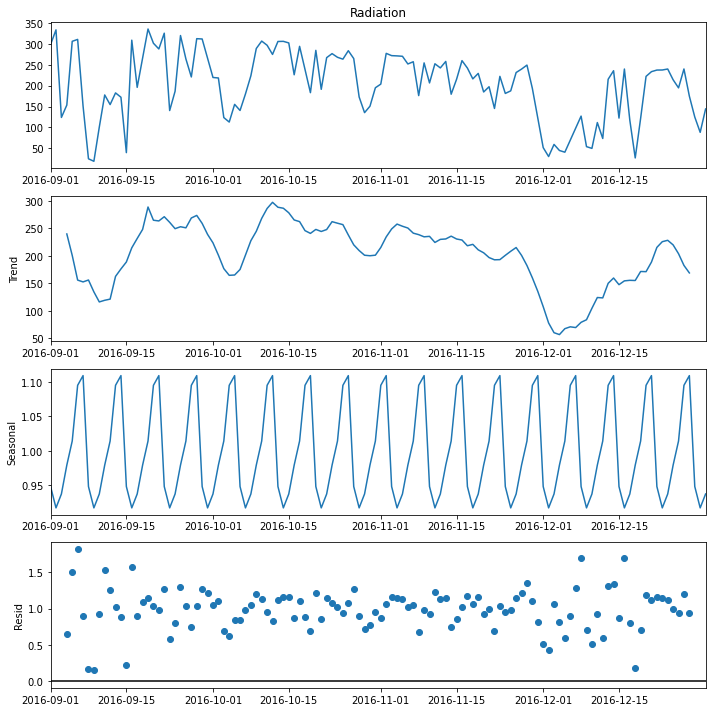

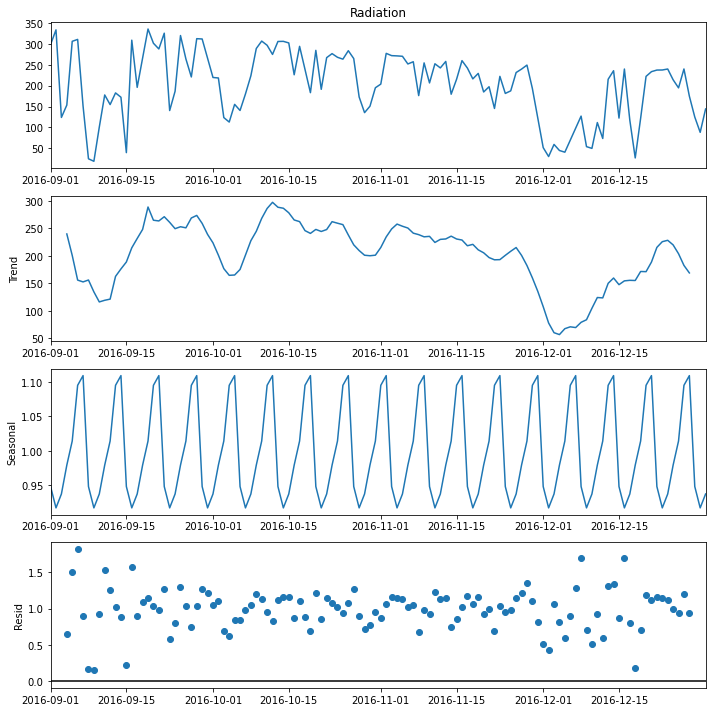

In [4]:
#Visuallising The trends 
import statsmodels.api as sm 
result=sm.tsa.seasonal_decompose(df_final, model='multiplicable')
plt.rcParams["figure.figsize"] = (10,10)
result.plot()

In [5]:
#Train-Test Split
train_size = int(len(df_final) * 0.67)
test_size = len(df_final) - train_size
train_set, test_set =  df_final.iloc[0:train_size], df_final.iloc[train_size:len(df_final)]

# ARIMA

In [38]:
#Improting the models
from statsmodels.tsa.arima.model import ARIMA 
import pmdarima as pm

In [9]:
#auto_arima to decide the best order
#model = pm.auto_arima(np.transpose(train_set))
#print(model.summary())

In [39]:
#Fitting the model with order 1,0,1
model = ARIMA(np.transpose(train_set), order=(1,0,1))
model_fit = model.fit()
ARIMA_training_predictions=model_fit.predict()

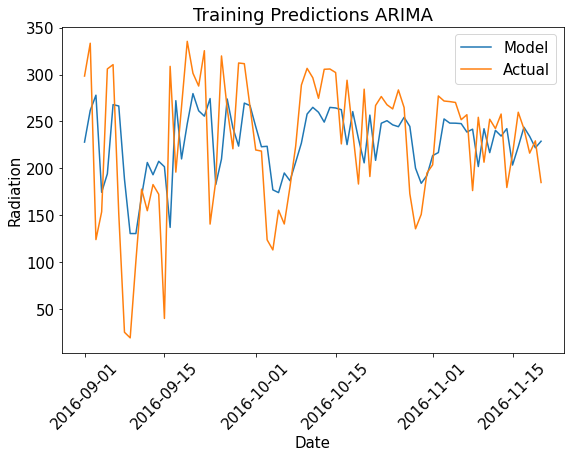

In [52]:
#Training predictions plot for ARIMA
plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams.update({'font.size': 15})
plt.plot(ARIMA_training_predictions, label="Model")
plt.plot(train_set, label="Actual")
plt.title('Training Predictions ARIMA')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [41]:
print("The training MAPE for the ARIMA model is:",MAPE(train_set,ARIMA_training_predictions))
print("The training RMSE for the ARIMA model is:",mean_squared_error(train_set,ARIMA_training_predictions, squared=False))

The training MAPE for the ARIMA model is: 40.49890445672577
The training RMSE for the ARIMA model is: 62.491813640237815


In [42]:
#The testing with ground truth (updating the history everytime then fitting)
history = [x for x in np.transpose(train_set)]
predictions = list()
for t in range(len(np.transpose(test_set))):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)#obs originally
    #print('predicted=%f, expected=%f' % (yhat, obs))
ARIMA_testing_predictions= pd.DataFrame(predictions,columns = ['Radiation'], index= test_set.index)

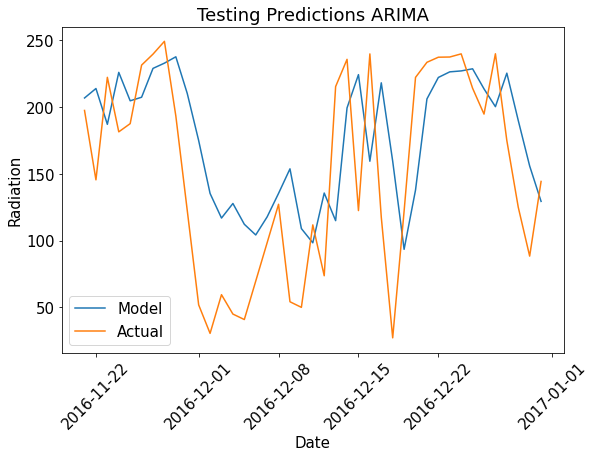

In [53]:
#Testing with ground truth plot for ARIMA
plt.plot(ARIMA_testing_predictions, label="Model")
plt.plot(test_set, label="Actual")
plt.title('Testing Predictions ARIMA')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [44]:
print("The testing MAPE for the ARIMA model is:",MAPE(test_set,ARIMA_testing_predictions.Radiation))
print("The testing RMSE for the ARIMA model is:",mean_squared_error(test_set,ARIMA_testing_predictions.Radiation, squared=False))

The testing MAPE for the ARIMA model is: 67.52534770626664
The testing RMSE for the ARIMA model is: 62.08872555583887


In [45]:
#7 day prediction without ground truth for ARIMA
model = ARIMA(np.transpose(train_set), order=(1,0,1))
model_fit = model.fit()
ARIMA_7day_predictions=model_fit.forecast(7)
#ARIMA_7day_predictions

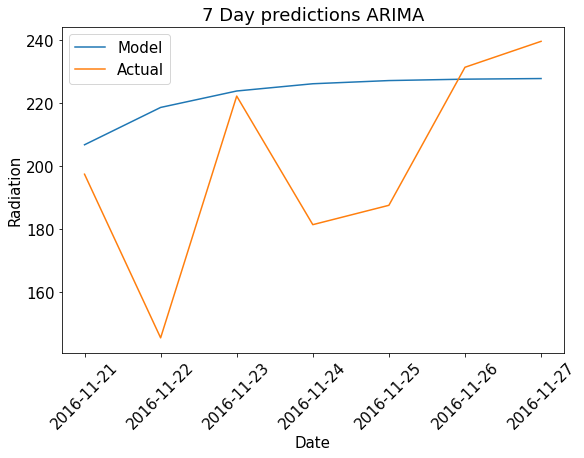

In [54]:
#7day prediction plot
plt.plot(ARIMA_7day_predictions, label="Model")
plt.plot(test_set[0:7], label="Actual")
plt.title('7 Day predictions ARIMA')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [19]:
print("The 7 day testing MAPE for the ARIMA model is:",MAPE(test_set[0:7],ARIMA_7day_predictions))
print("The 7 day testing RMSE for the AIRMA model is:",mean_squared_error(test_set[0:7],ARIMA_7day_predictions, squared=False))

The 7 day testing MAPE for the ARMA model is: 15.441375809910038
The 7 day testing RMSE for the ARMA model is: 36.19012359296344


# Exponential Smoothing

In [57]:
#importing exponential smoothing model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
#from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [58]:
#fitting the model
modelexp = SimpleExpSmoothing(train_set)
model_fitexp = modelexp.fit()
EXP_training_predictions=model_fitexp.predict(start=0, end=len(train_set)-1)

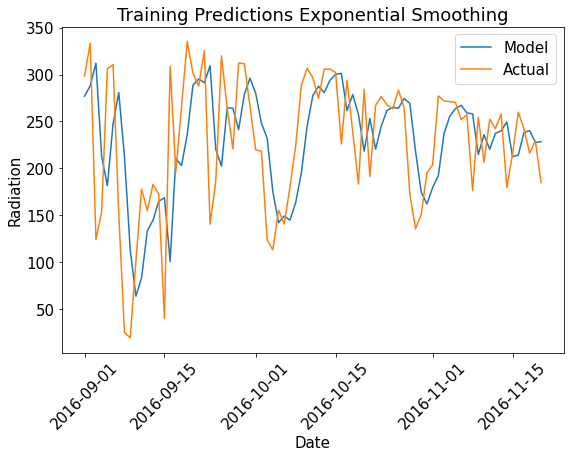

In [59]:
#training predictions for exponential smoothing
plt.plot(EXP_training_predictions, label="Model")
plt.plot(train_set, label="Actual")
plt.title('Training Predictions Exponential Smoothing')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [60]:
print("The training MAPE for the Exponential Smoothing model is:",MAPE(train_set,EXP_training_predictions))
print("The training RMSE for the Exponential Smoothing model is:",mean_squared_error(train_set,EXP_training_predictions, squared=False))

The training MAPE for the Exponential Smoothing model is: 41.58051471142908
The training RMSE for the Exponential Smoothing model is: 67.95633580829143


In [61]:
#testing predictions with ground truth for exponential smoothing
history = [x for x in np.transpose(train_set)]
predictions = list()
for t in range(len(np.transpose(test_set))):
    model = SimpleExpSmoothing(history)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)#obs originally
    #print('predicted=%f, expected=%f' % (yhat, obs))
EXP_testing_predictions= pd.DataFrame(predictions,columns = ['Radiation'], index= test_set.index)

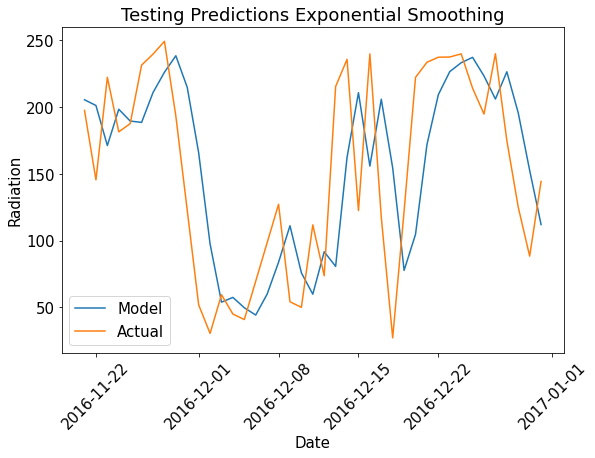

In [62]:
#Testing predictions with ground truth plot
plt.plot(EXP_testing_predictions, label="Model")
plt.plot(test_set, label="Actual")
plt.title('Testing Predictions Exponential Smoothing')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [63]:
print("The testing MAPE for the Exponential Smoothing model is:",MAPE(test_set,EXP_testing_predictions.Radiation))
print("The testing RMSE for the Exponential Smoothing model is:",mean_squared_error(test_set,EXP_testing_predictions.Radiation, squared=False))

The testing MAPE for the Exponential Smoothing model is: 52.4325339779706
The testing RMSE for the Exponential Smoothing model is: 59.82028467229245


In [64]:
#7day prediction prediction without ground truth exponential smoothing
model = SimpleExpSmoothing(train_set)
model_fit = model.fit()
EXP_noground_pred=model_fit.forecast(len(test_set))
#EXP_noground_pred

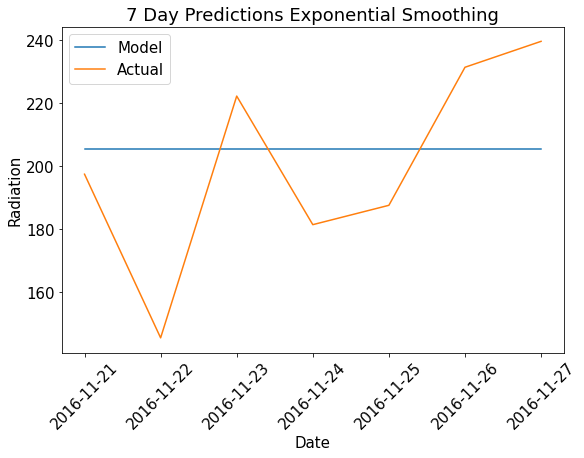

In [65]:
#7day prediction plot exponential smoothing
plt.plot(EXP_noground_pred[0:7], label="Model")
plt.plot(test_set[0:7], label="Actual")
plt.title('7 Day Predictions Exponential Smoothing')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [66]:
print("The 7 day testing MAPE for the EXP model is:",MAPE(test_set[0:7],EXP_noground_pred[0:7]))
print("The 7 day testing RMSE for the EXP model is:",mean_squared_error(test_set[0:7],EXP_noground_pred[0:7], squared=False))

The 7 day testing MAPE for the EXP model is: 14.439690320676593
The 7 day testing RMSE for the EXP model is: 30.894876824514032


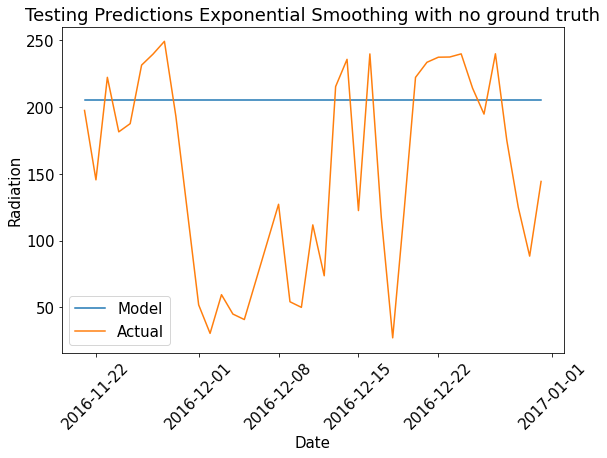

In [67]:
#Expanding the the testing without ground truth to the full test set for comparisons with the Neural Prophet model
plt.plot(EXP_noground_pred, label="Model")
plt.plot(test_set, label="Actual")
plt.title('Testing Predictions Exponential Smoothing with no ground truth')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [68]:
print("The testing MAPE with no ground truth for the EXP model is:",MAPE(test_set,EXP_noground_pred))
print("The testing RMSE with no ground truth for the EXP model is:",mean_squared_error(test_set,EXP_noground_pred, squared=False))

The testing MAPE with no ground truth for the EXP model is: 110.39996817010054
The testing RMSE with no ground truth for the EXP model is: 90.96664717194146


# LSTM

In [22]:
##LSTM
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [23]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
 

In [24]:
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataset = df_final.values
dataset = np.array(df_final.astype('float32'))
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [25]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Epoch 1/100
79/79 - 3s - loss: 0.3727 - 3s/epoch - 34ms/step
Epoch 2/100
79/79 - 0s - loss: 0.2363 - 131ms/epoch - 2ms/step
Epoch 3/100
79/79 - 0s - loss: 0.1371 - 126ms/epoch - 2ms/step
Epoch 4/100
79/79 - 0s - loss: 0.0774 - 121ms/epoch - 2ms/step
Epoch 5/100
79/79 - 0s - loss: 0.0508 - 130ms/epoch - 2ms/step
Epoch 6/100
79/79 - 0s - loss: 0.0430 - 137ms/epoch - 2ms/step
Epoch 7/100
79/79 - 0s - loss: 0.0411 - 151ms/epoch - 2ms/step
Epoch 8/100
79/79 - 0s - loss: 0.0407 - 149ms/epoch - 2ms/step
Epoch 9/100
79/79 - 0s - loss: 0.0408 - 134ms/epoch - 2ms/step
Epoch 10/100
79/79 - 0s - loss: 0.0407 - 144ms/epoch - 2ms/step
Epoch 11/100
79/79 - 0s - loss: 0.0407 - 140ms/epoch - 2ms/step
Epoch 12/100
79/79 - 0s - loss: 0.0404 - 170ms/epoch - 2ms/step
Epoch 13/100
79/79 - 0s - loss: 0.0405 - 126ms/epoch - 2ms/step
Epoch 14/100
79/79 - 0s - loss: 0.0403 - 119ms/epoch - 2ms/step
Epoch 15/100
79/79 - 0s - loss: 0.0407 - 117ms/epoch - 1ms/step
Epoch 16/100
79/79 - 0s - loss: 0.0403 - 112ms/epoc

In [27]:
# calculate root mean squared error
# training and testing with ground truth
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 62.35 RMSE
Test Score: 69.37 RMSE


In [28]:
#MAPE training and testing with ground truth
print('Training Score: MAPE', MAPE(trainY[0], trainPredict[:,0]))
print('Testing Score: MAPE', MAPE(testY[0], testPredict[:,0]))

Training Score: MAPE 40.38968001340475
Testing Score: MAPE 80.80604721409719


In [29]:
#7Days no ground truth testing
pre=testX[0]
output_noground=np.zeros(len(testX))
for i in range(len(testX)):
  outpred=model.predict([pre])
  output_noground[i]=outpred
  pre=outpred
LSTM_out_pred=scaler.inverse_transform(output_noground.reshape(-1, 1))

1/1 [==============================] - 0s 22ms/step


In [50]:
# 7 days MAPE and RMSE
print('Testing 7day Score: MAPE', MAPE(testY[0][0:7], LSTM_out_pred[0:7]))
test7Score = np.sqrt(mean_squared_error(testY[0][0:7], LSTM_out_pred[0:7]))
print('Testing 7day Score: RMSE', test7Score)

Testing 7day Score: MAPE 17.174178045842098
Testing 7day Score: RMSE 35.76743634556233


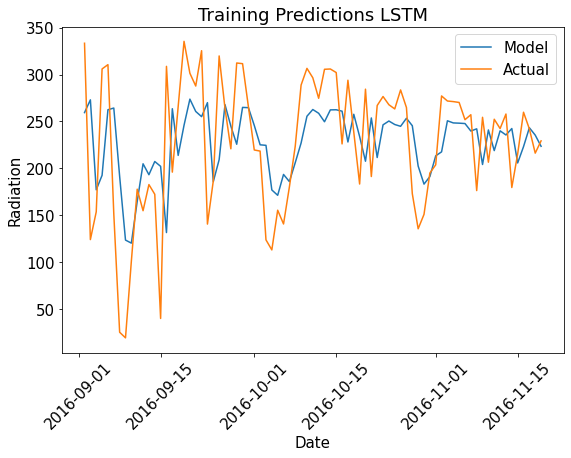

In [69]:
#Training predictions plot LSTM
plt.plot(train_set[1:-1].index, trainPredict[:,0], label="Model")
plt.plot(train_set[1:-1].index,trainY[0], label="Actual")
plt.title('Training Predictions LSTM')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

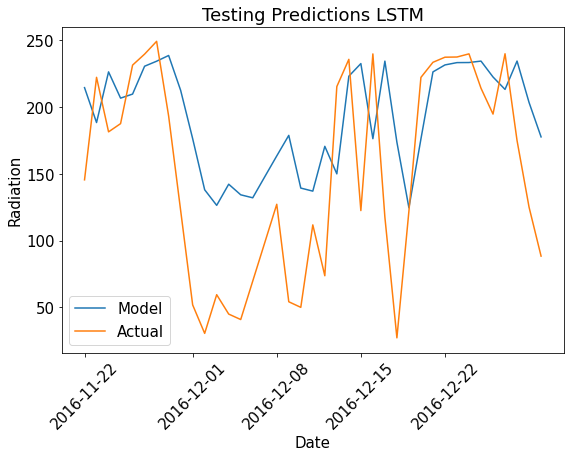

In [70]:
#Testing Predictions with ground truth plot LSTM
plt.plot(test_set[1:-1].index, testPredict[:,0], label="Model")
plt.plot(test_set[1:-1].index,testY[0], label="Actual")
plt.title('Testing Predictions LSTM')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

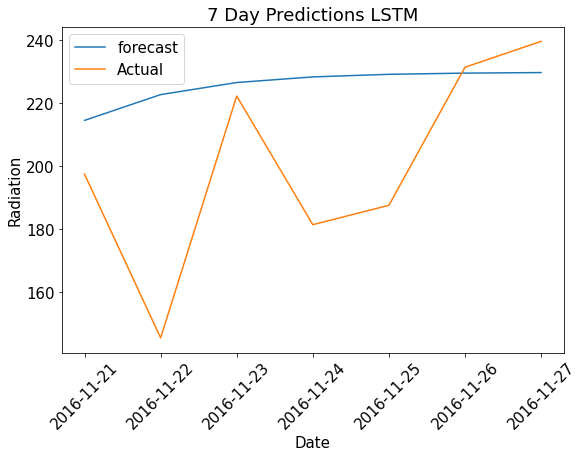

In [71]:
#7 day testing Predictions without ground truth plot LSTM
day7lstm=LSTM_out_pred[0:7]
plt.plot(test_set[0:7].index, day7lstm, label="forecast")
plt.plot(test_set[0:7], label="Actual")
plt.title('7 Day Predictions LSTM')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

# NeuralProphet

In [6]:
#pip install neuralprophet
from neuralprophet import NeuralProphet

In [7]:
#Creating a new data frame "nuo" as the model takes 2 inputs: date as "ds" and the values as "y"
nuo=pd.DataFrame(train_set)
nuo["ds"]= nuo.index
nuo['ds'] = pd.DatetimeIndex(nuo['ds'])
nuo = nuo.rename(columns={'Radiation': 'y'})

nuo_test=pd.DataFrame(test_set)
nuo_test["ds"]= nuo_test.index
nuo_test['ds'] = pd.DatetimeIndex(nuo_test['ds'])
nuo_test = nuo_test.rename(columns={'Radiation': 'y'})

In [8]:
from neuralprophet import set_random_seed 
set_random_seed(177) #for reproducibility

m = NeuralProphet(weekly_seasonality=True)
#we use aa part of the training data as a validation set
metrics = m.fit(nuo, freq='D', validation_df=nuo.tail(27))


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 617


  0%|          | 0/106 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.21E-02, min: 1.81E-01


  0%|          | 0/106 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.21E-02, min: 1.81E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.77E-02
Epoch[617/617]: 100%|█| 617/617 [00:08<00:00, 69.58it/s, SmoothL1Loss=0.0181, MAE=43.4, RMSE=54.8, RegLoss=0, MAE_val=2


In [9]:
#Predicting the training set
future_training = m.make_future_dataframe(nuo, periods=0, n_historic_predictions=len(nuo))
training_pred_prophet = m.predict(future_training)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


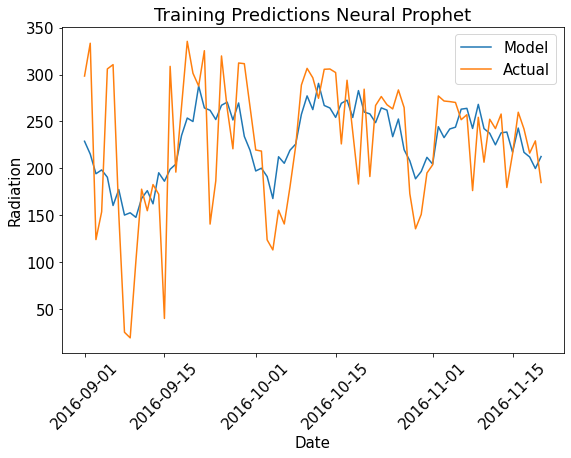

In [72]:
#Training Prediction plots
plt.plot(train_set.index,training_pred_prophet["yhat1"], label="Model")
plt.plot(train_set, label="Actual")
plt.title('Training Predictions Neural Prophet')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [13]:
#MAPE and RMSE on the training set
print('Training neural prophet Score: MAPE', MAPE(training_pred_prophet["y"], training_pred_prophet["yhat1"]))
print("Training neural prophet Score: RMSE:",mean_squared_error(training_pred_prophet["y"], training_pred_prophet["yhat1"], squared=False))

Training neural prophet Score: MAPE 37.382243147809284
Training neural prophet Score: RMSE: 55.734816949829565


In [14]:
#Testing set predictions
future = m.make_future_dataframe(nuo_test, periods=0, n_historic_predictions=len(nuo))
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.561% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 81 historic forecasts, reduced to 41.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.561% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.561% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


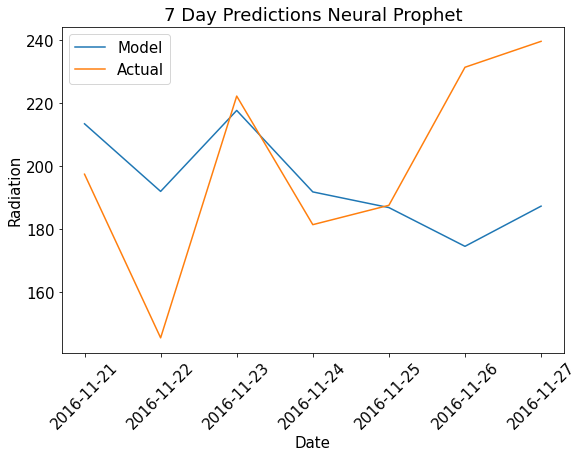

In [73]:
#7 Day testing prediction
plt.plot(test_set[0:7].index,forecast["yhat1"][0:7], label="Model")
plt.plot(test_set[0:7], label="Actual")
plt.title('7 Day Predictions Neural Prophet')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [16]:
#7 day testing MAPE and RMSE
print('Testing neural prophet Score: MAPE', MAPE(forecast["y"][0:7], forecast["yhat1"][0:7]))
print("Testing neural prophet Score: RMSE",mean_squared_error(forecast["y"][0:7], forecast["yhat1"][0:7], squared=False))

Testing neural prophet Score: MAPE 13.520920208398355
Testing neural prophet Score: RMSE 34.88874896968005


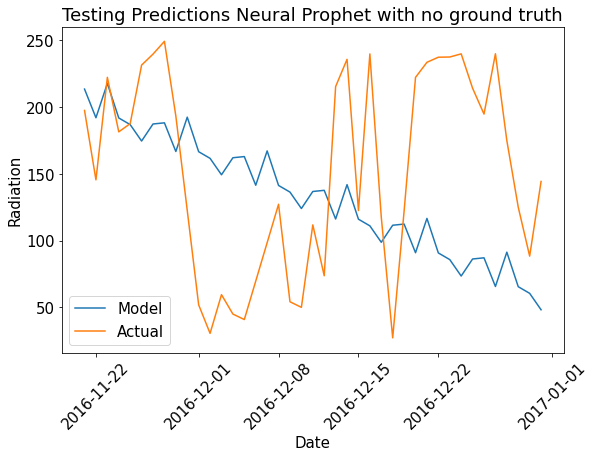

In [74]:
#Full testing set predictions plot with no ground truth
plt.plot(test_set.index,forecast["yhat1"], label="Model")
plt.plot(test_set, label="Actual")
plt.title('Testing Predictions Neural Prophet with no ground truth')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Radiation')
plt.legend(loc='best')
plt.show()

In [18]:
#Full testing set predictions with no ground truth
print('Testing neural prophet Score: MAPE', MAPE(forecast["y"], forecast["yhat1"]))
print("Testing neural prophet Score: RMSE",mean_squared_error(forecast["y"], forecast["yhat1"], squared=False))

Testing neural prophet Score: MAPE 80.69797986168966
Testing neural prophet Score: RMSE 90.61644681520734
